Neural network classification with pytorch

Make classification data

In [28]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
samples = 1000

# create circles
X, y = make_circles(samples, noise=0.03, random_state=42)
len(X), len(y)

(1000, 1000)

In [29]:
# make dataframe of cicle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], 
                        "x2": X[:,1],
                        "label": y})

circles.head(10)

,X1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


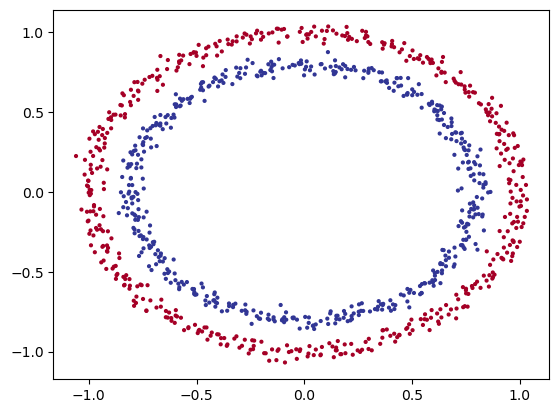

In [30]:
# visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:,1],
            c=y,
            s=4,
            cmap=plt.cm.RdYlBu)

In [31]:
# check input and output shapes
X.shape, y.shape
type(X)

numpy.ndarray

In [32]:
# Turn data into tensors
import torch
# X = torch.from_numpy(X).type(torch.float) # previous X is numpy array
# y = torch.from_numpy(y).type(torch.float32)

In [33]:
# create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,     # 0.2 = 20% of data will be test and 80% for training
                                                    random_state=42)  

In [34]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

> #### Building model to classify our blue and red dots.<br>
**Steps** :-<br>
> **1** Setup device agnostic code. <br>
> **2** :- Construct a model (by subclassing `nn.Module`). <br>
**3** :- Define a loss function and optimizer. <br>
**4** :- Create a training and testing loop.

In [35]:
from torch import nn

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

> #### Create model <br>
>> subclass `nn.Module`. <br>
>> create two `nn.Linear()`. <br>
>> Define a `forward()` method for forward propagaion. <br>
>> Create a instance of our model and send it to the target device. <br>

In [36]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # create two linear layer
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # out_features of this layer must layer must match in_features of next layer
        self.layer_2 = nn.Linear(in_features=5, out_features=1)   # out_feature same shape as y

    def forward(self, x):
        return self.layer_2(self.layer_1(x))  # x goes to layer 1 and the output of layer 1 goes to layer 2

In [37]:
# Creating instance of model and sending it to the target device
model_0 = CircleModel().to(device=device)
model_0
# next(model_0.parameters()).device

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

model creating by `nn.Module `allow more flexibility to the model this is suitable if we want to create complex model. <br>
where creating model by `nn.Sequetial()` is good for simple model.

In [38]:
# lets's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device=device)
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5798, -0.6585],
                      [-0.5253, -0.2544],
                      [-0.0288,  0.3029],
                      [ 0.3784, -0.6503],
                      [-0.6563, -0.4158]])),
             ('0.bias', tensor([ 0.4709,  0.1670, -0.1177,  0.2517,  0.1921])),
             ('1.weight',
              tensor([[ 0.3669, -0.2605, -0.3531, -0.0449,  0.1810]])),
             ('1.bias', tensor([-0.2649]))])

In [39]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
len(untrained_preds)
untrained_preds[:10]

AttributeError: 'numpy.ndarray' object has no attribute 'to'

### Setup loss function and optimizer

In [22]:
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [23]:
# calculate accurary - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()   # torch.er returns boolean, sum will sum all the true, .item convert that number from tensor to python integer
    acc = (correct/len(y_pred)) * 100
    return acc

### Training
* Forward pass.
* Calculate the loss.
* Optimizer zero grad.
* Loss backward (backpropagation).
* Optimizer step (gradient descent).

our model outputs are going to be raw `logits`. <br>
We can convert these logists into `prediction probabilities` by passing them to some kind of activation function(eg:-sigmoid for binary classification and softmax for mullicalss classification). <br>
Then wen can convet out model's prediction probabilities to `prediction labels` by either rounding the or taking the `argmax()`.

In [27]:
# View the first 5 outputs of the foward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [25]:
# use the sigmoid activation function on out model logits to turn them into prediction probabilities
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

NameError: name 'y_logits' is not defined

In [26]:
torch.round(y_pred_prob)

NameError: name 'y_pred_prob' is not defined

### Building testing and training loop

In [ ]:
torch.manual_seed(42)

# set number of epochs
epochs = 100

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# buind training and evaluation loop
for epoch in range(epochs):
    #training
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))   # turn logits  -> pred probs -> pred labels

    # 2. loss/accuracy
    loss = loss_fn(y_logits,    # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward (backpropagation)
    loss.backward()

    # 5. optimizer step (gradient descent)
    optimizer.step()


    # testing
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # print
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss:.5f}, acc: {acc:.2f}% | test loss: {test_loss:.5f}, test acc: {test_acc:.2f}%")



Epoch: 0 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 10 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 20 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 30 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 40 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 50 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 60 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 70 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 80 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%
Epoch: 90 | loss: 0.69618, acc: 48.88% | test loss: 0.70209, test acc: 46.50%


### make predictions and evaluate the model

from the metrics it looks like out model isn't learning anything <br>
so to inspect it let's make some prediction and make them visual <br>
to do so, we're going to import a function called  `plot_decision_boundary()`

In [ ]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded.)
if Path("helper_functions.py").is_file():
    print("helper_function.py already exists.")
else:
    print("Download helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_function.py already exists.


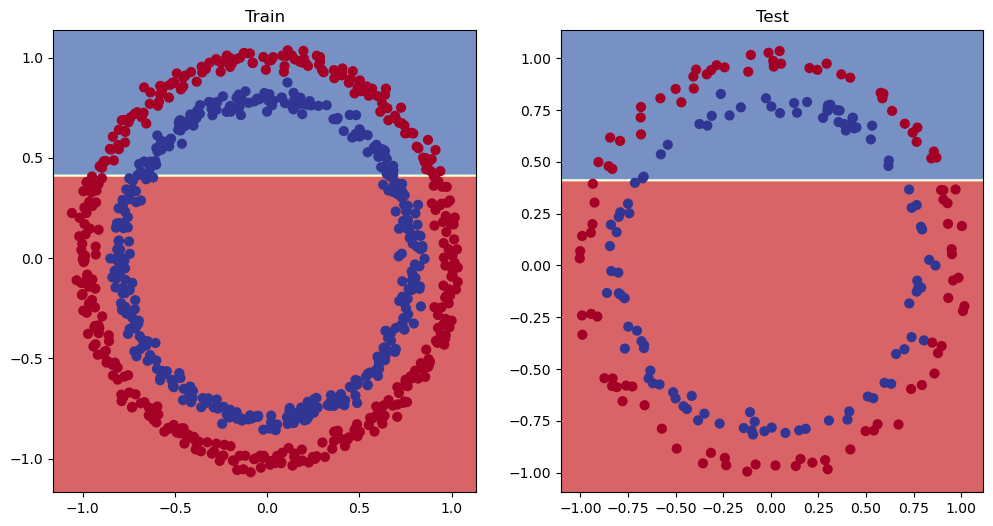

In [ ]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Improve model (from model prespective) <br>
> Possible ways to improve model. <br>

* Add more layers -. give the model mode chance to learn about patterns in the data. <br>
* Add more hidden units - go from 5 hidden units to 10 hidden units. <br>
* Changing the activation functions. <br>
* Change the learning rate. <br>
* Change the loss function. <br>

In [ ]:
# Improvement 1 :- Increase number of layers.
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)   # z is logits
        # z = self.layer_2(z)
        # z = self.layer_3(z)

        return self.layer_3(self.layer_2(self.layer_1(x)))     # it speed us the process
    
model_1 = CircleModelV1().to(device=device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# create loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in

# create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


In [ ]:
# Writing training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()

    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))   # logits to prediction probabilities to prediction label

    # loss calculation/ accuarcy calculation
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward (back propagation)
    loss.backward()

    # update gradients (gradient descent)
    optimizer.step()


    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        

    # print
    if epoch % 100 == 0:
        print(f"epoch: {epoch} | loss: {loss:.5f}, | acc: {acc:.2f}%, | test loss: {test_loss:.5f}, | test acc: {test_acc:.2f}%")


epoch: 0 | loss: 0.69396, | acc: 50.88%, | test loss: 0.69261, | test acc: 51.00%
epoch: 100 | loss: 0.69305, | acc: 50.38%, | test loss: 0.69379, | test acc: 48.00%
epoch: 200 | loss: 0.69299, | acc: 51.12%, | test loss: 0.69437, | test acc: 46.00%
epoch: 300 | loss: 0.69298, | acc: 51.62%, | test loss: 0.69458, | test acc: 45.00%
epoch: 400 | loss: 0.69298, | acc: 51.12%, | test loss: 0.69465, | test acc: 46.00%
epoch: 500 | loss: 0.69298, | acc: 51.00%, | test loss: 0.69467, | test acc: 46.00%
epoch: 600 | loss: 0.69298, | acc: 51.00%, | test loss: 0.69468, | test acc: 46.00%
epoch: 700 | loss: 0.69298, | acc: 51.00%, | test loss: 0.69468, | test acc: 46.00%
epoch: 800 | loss: 0.69298, | acc: 51.00%, | test loss: 0.69468, | test acc: 46.00%
epoch: 900 | loss: 0.69298, | acc: 51.00%, | test loss: 0.69468, | test acc: 46.00%


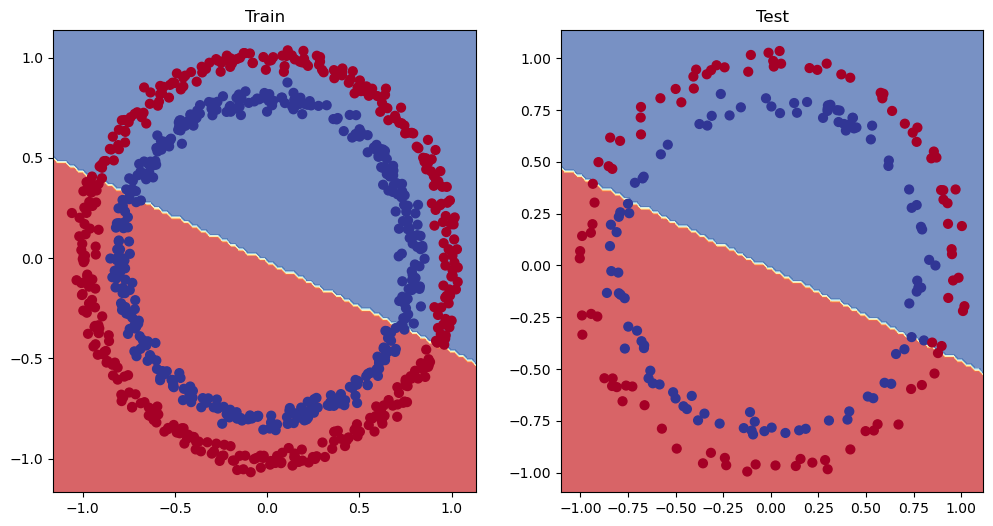

In [ ]:
# plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Preparing data to see if our model can fit a straight line

In [ ]:
# create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# check the data
y_regression[:5], X_regression[:5]

(tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]),
 tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]))

In [ ]:
# train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]



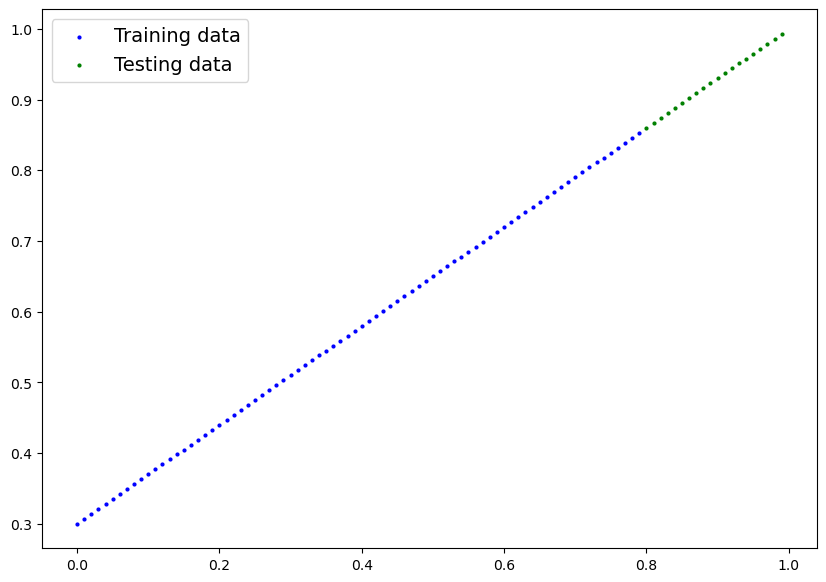

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

#### Adjusting `model_1` to fit a straight line.

In [ ]:
# Same architecture as model_1 (but using nn.Sequential())

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [ ]:
# training and evaluating model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()

    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # print
    if epoch % 100 == 0:
        print(f"epoch: {epoch} | loss: {loss:.2f} | test loss: {test_loss:.5f}")

epoch: 0 | loss: 0.76 | test loss: 0.54143
epoch: 100 | loss: 0.09 | test loss: 0.02901
epoch: 200 | loss: 0.07 | test loss: 0.02850
epoch: 300 | loss: 0.07 | test loss: 0.00615
epoch: 400 | loss: 0.06 | test loss: 0.02004
epoch: 500 | loss: 0.06 | test loss: 0.01061
epoch: 600 | loss: 0.05 | test loss: 0.01326
epoch: 700 | loss: 0.06 | test loss: 0.02127
epoch: 800 | loss: 0.06 | test loss: 0.01425
epoch: 900 | loss: 0.06 | test loss: 0.00603


### Recreating non-linear data(red and blue circles)

numpy.ndarray

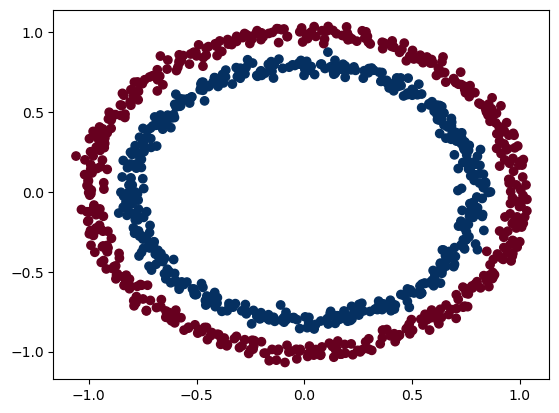

In [ ]:
# make and plot data
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
type(X)


In [ ]:
# convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split
import numpy as np

# turn data into tensors
X = torch.from_numpy(X).type(torch.float) if isinstance(X, np.ndarray) else X
y = torch.from_numpy(y).type(torch.float) if isinstance(y, np.ndarray) else y

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### Building model with non-linearity
Artificial neural network are a larger combination of linear and non-linear functions which are potentially able to find patterns in data.

In [ ]:
# build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=30)
        self.layer_2 = nn.Linear(in_features=30, out_features=30)
        self.layer_3 = nn.Linear(in_features=30, out_features=1)
        self.relu = nn.ReLU()    # relu is a non-linear activation function if input is <= 0 output is 0, else input = output

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    # explaination :-
    # input goes to each layer and before passing to next layer it goes through relu activation function

# creating instance of the model
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# setup loss and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)


In [ ]:
# training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put all data on target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# loop through data
epochs = 1000

for epoch in range(epochs):
    model_3.train()

    # forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss calculation
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # back propagtion
    loss.backward()

    # step the optimizer (gradient descent)
    optimizer.step()


    ## testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)


    # print
    if epoch % 100 == 0: 
        print(f"epoch: {epoch} | loss:{loss:.4f} | acc: {acc:.2f} | test loss: {test_loss:.5f} | test acc: {test_acc:.2f}")

epoch: 0 | loss:0.6943 | acc: 50.00 | test loss: 0.69391 | test acc: 50.00
epoch: 100 | loss:0.6898 | acc: 53.50 | test loss: 0.68987 | test acc: 52.50
epoch: 200 | loss:0.6855 | acc: 62.38 | test loss: 0.68636 | test acc: 61.00
epoch: 300 | loss:0.6789 | acc: 69.25 | test loss: 0.68109 | test acc: 66.00
epoch: 400 | loss:0.6674 | acc: 77.62 | test loss: 0.67127 | test acc: 76.50
epoch: 500 | loss:0.6453 | acc: 89.38 | test loss: 0.65176 | test acc: 86.00
epoch: 600 | loss:0.6025 | acc: 94.38 | test loss: 0.61414 | test acc: 91.00
epoch: 700 | loss:0.5180 | acc: 98.38 | test loss: 0.53965 | test acc: 95.50
epoch: 800 | loss:0.3810 | acc: 99.12 | test loss: 0.41781 | test acc: 97.50
epoch: 900 | loss:0.2372 | acc: 99.75 | test loss: 0.28461 | test acc: 99.00


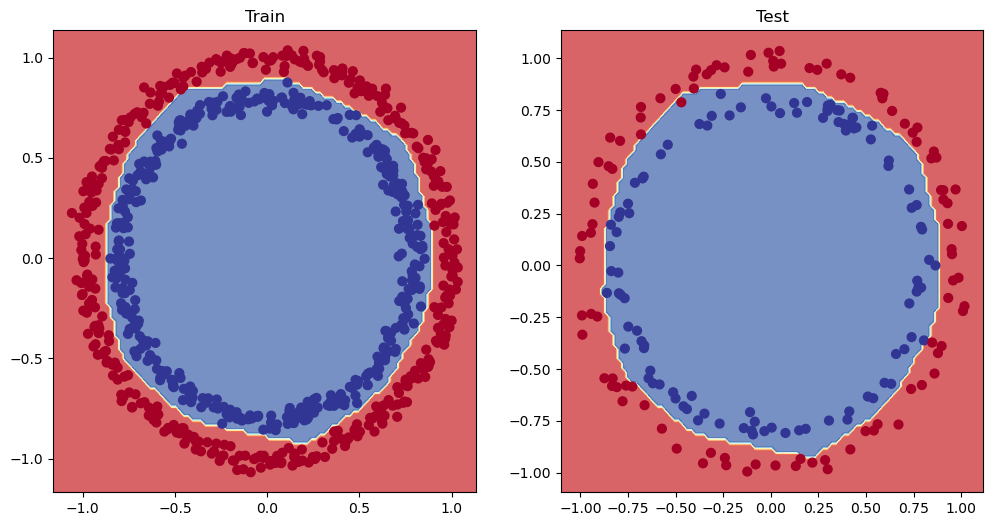

In [ ]:
## evaluating model
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10]

# plot 
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_3, X = X_train, y = y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_3, X = X_test, y = y_test)

### Putting all together with a multi-class classification problem.

#### Creating a toy multi-class dataset

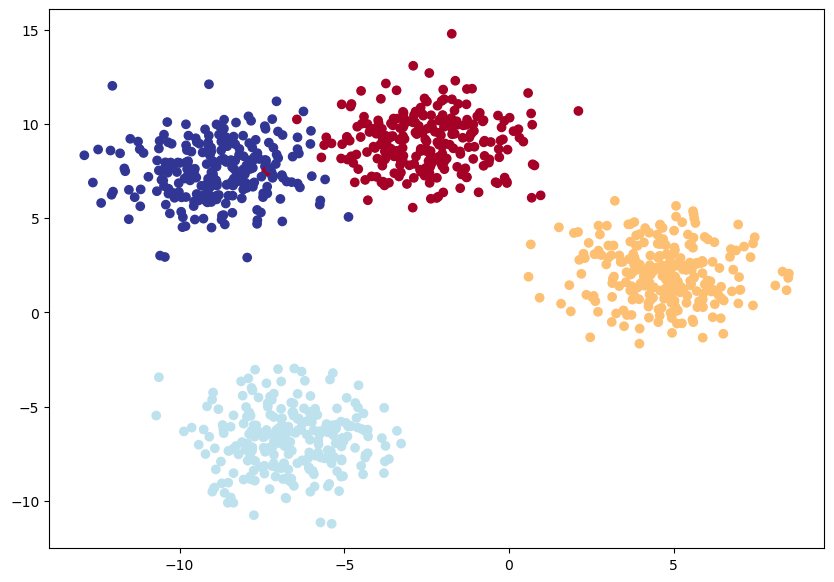

In [ ]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,       # noise
                            random_state=RANDOM_SEED,
                            )

# sklear uses numpy so we have to convert data to the tensors
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)





#### Buildig a multi-class classification model.

In [ ]:
# Creating device agnostic code.
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
            Initializes multi-class clssification model.

            Args:
                input_features (int): Number of input features to the model
                output_features (int): Number of output features (number of output classes)
                hidden_units (int): Number of hidden units between layers

            Returns:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# create an instance and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
# create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [ ]:
# training
# fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # training
    model_4.train()

    # forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)


    # loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # zero grad optimizer
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # gradient descent
    optimizer.step()

    ## testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

        # print
        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss:.4f} | acc : {acc:.2f} | test loss: {test_loss:.4f} | test acc: {test_acc:.2f}")

epoch: 0 | loss: 1.1588 | acc : 40.38 | test loss: 1.0755 | test acc: 48.00
epoch: 10 | loss: 0.6448 | acc : 96.75 | test loss: 0.6607 | test acc: 97.50
epoch: 20 | loss: 0.4254 | acc : 98.50 | test loss: 0.4307 | test acc: 100.00
epoch: 30 | loss: 0.2529 | acc : 99.12 | test loss: 0.2451 | test acc: 99.50
epoch: 40 | loss: 0.1123 | acc : 99.25 | test loss: 0.1023 | test acc: 99.50
epoch: 50 | loss: 0.0663 | acc : 99.25 | test loss: 0.0585 | test acc: 99.50
epoch: 60 | loss: 0.0507 | acc : 99.25 | test loss: 0.0429 | test acc: 99.50
epoch: 70 | loss: 0.0430 | acc : 99.25 | test loss: 0.0349 | test acc: 99.50
epoch: 80 | loss: 0.0384 | acc : 99.25 | test loss: 0.0299 | test acc: 99.50
epoch: 90 | loss: 0.0352 | acc : 99.25 | test loss: 0.0266 | test acc: 99.50


In [ ]:
# evaluation
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [ ]:
# logits to prediction probabilities
y_pred_prob = torch.softmax(y_logits, dim=1)
y_pred_prob[:5]

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05]])

In [ ]:
# pred probs to pred labels
y_preds = torch.argmax(y_pred_prob, dim=1)
y_preds[:5]

tensor([1, 3, 2, 1, 0])

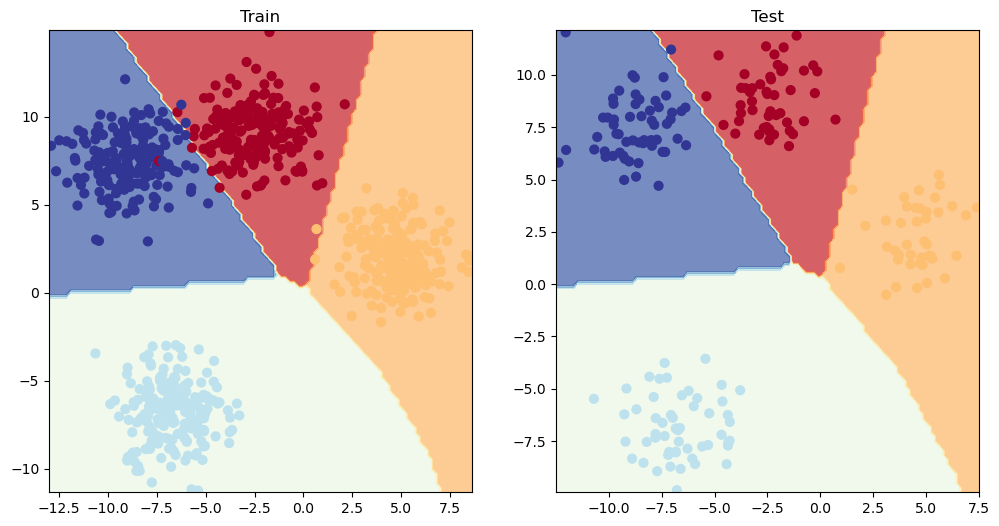

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_4, X = X_blob_train, y = y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_4, X = X_blob_test, y = y_blob_test)

In [ ]:
from torchmetrics import Accuracy

# setup metrics
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

NameError: name 'device' is not defined